# LightGBM Parameter Tuning for Otto Dataset

## 1. 直接调用LightGBM内嵌的cv寻找最佳的参数n_estimators

我们以Kaggle 2015年举办的Otto Group Product Classification Challenge竞赛数据为例，进行XGBoost参数调优探索。

竞赛官网：https://www.kaggle.com/c/otto-group-product-classification-challenge/data

首先 import 必要的模块

In [1]:
#from xgboost import XGBClassifier
import lightgbm as lgbm
#from lgbm.sklearn import LGBMClassifier

import pandas as pd 
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import log_loss

from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

## 读取数据

In [2]:
# path to where the data lies
dpath = '../data/'
train = pd.read_csv(dpath +"Otto_train.csv")
#train.head()

## Variable Identification

选择该数据集是因为的数据特征单一，我们可以在特征工程方面少做些工作，集中精力放在参数调优上

## Target 分布，看看各类样本分布是否均衡

In [3]:
#sns.countplot(train.target);
#pyplot.xlabel('target');
#pyplot.ylabel('Number of occurrences');

每类样本分布不是很均匀

In [4]:
# drop ids and get labels
y_train = train['target']
y_train = y_train.map(lambda s: s[6:])
y_train = y_train.map(lambda s: int(s)-1)

train = train.drop(["id", "target"], axis=1)
X_train = np.array(train)

默认参数，此时学习率为0.1，比较大，观察弱分类数目的大致范围
（采用默认参数配置，看看模型是过拟合还是欠拟合）

In [5]:
#直接调用xgboost内嵌的交叉验证（cv），可对连续的n_estimators参数进行快速交叉验证
#而GridSearchCV只能对有限个参数进行交叉验证
import json
def modelfit(params, alg, X_train, y_train, early_stopping_rounds=10):
    lgbm_params = params.copy()
    lgbm_params['num_class'] = 9
    
    #直接调用xgboost，而非sklarn的wrapper类
    lgbmtrain = lgbm.Dataset(X_train, y_train, silent=True)
    
    cv_result = lgbm.cv(
        lgbm_params, lgbmtrain, num_boost_round=10000, nfold=5, stratified=False, shuffle=True, metrics='multi_logloss',
        early_stopping_rounds=early_stopping_rounds,show_stdv=True,seed=0)
    # note: cv_results will look like: {"multi_logloss-mean": <a list of historical mean>,
    # "multi_logloss-stdv": <a list of historical standard deviation>}
    print('best n_estimators:', len(cv_result['multi_logloss-mean']))
    print('best cv score:', cv_result['multi_logloss-mean'][-1])
    #cv_result.to_csv('lgbm1_nestimators.csv', index_label = 'n_estimators')
    json.dump(cv_result, open('lgbm_1.json', 'w'))
    
    # 采用交叉验证得到的最佳参数n_estimators，训练模型
    alg.set_params(n_estimators = len(cv_result['multi_logloss-mean']))
    alg.fit(X_train, y_train)

In [6]:
params = {'boosting_type': 'gbdt', 
          'objective': 'multiclass', 
          'nthread': -1, 
          'silent': True,
          'learning_rate': 0.1, 
          'num_leaves': 80, 
          'max_depth': 5,
          'max_bin': 127, 
          'subsample_for_bin': 50000,
          'subsample': 0.8, 
          'subsample_freq': 1, 
          'colsample_bytree': 0.8, 
          'reg_alpha': 1, 
          'reg_lambda': 0,
          'min_split_gain': 0.0, 
          'min_child_weight': 1, 
          'min_child_samples': 20, 
          'scale_pos_weight': 1}

lgbm1 = lgbm.sklearn.LGBMClassifier(n_estimators=1000, seed=0, **params)

modelfit(params,lgbm1, X_train, y_train)

/usr/local/python36/lib/python3.6/site-packages/lightgbm/basic.py:741: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


best n_estimators: 738
best cv score: 0.580271453084524


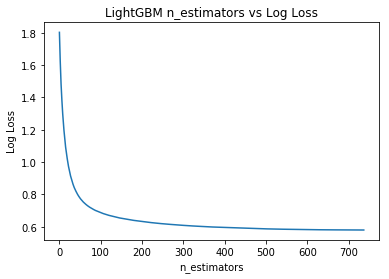

In [7]:
#cv_result = pd.DataFrame.from_csv('lgbm1_nestimators.csv')
cv_result = pd.read_json("lgbm_1.json")

# plot
test_means = cv_result['multi_logloss-mean']
#test_stds = cv_result['multi_logloss-std'] 

x_axis = range(0, cv_result.shape[0])
pyplot.plot(x_axis, test_means) 

pyplot.title("LightGBM n_estimators vs Log Loss")
pyplot.xlabel( 'n_estimators' )
pyplot.ylabel( 'Log Loss' )
pyplot.savefig( 'lgbm1_n_estimators.png')

pyplot.show()